In [1]:
import pandas as pd
import numpy as np 
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"


In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [4]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [5]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


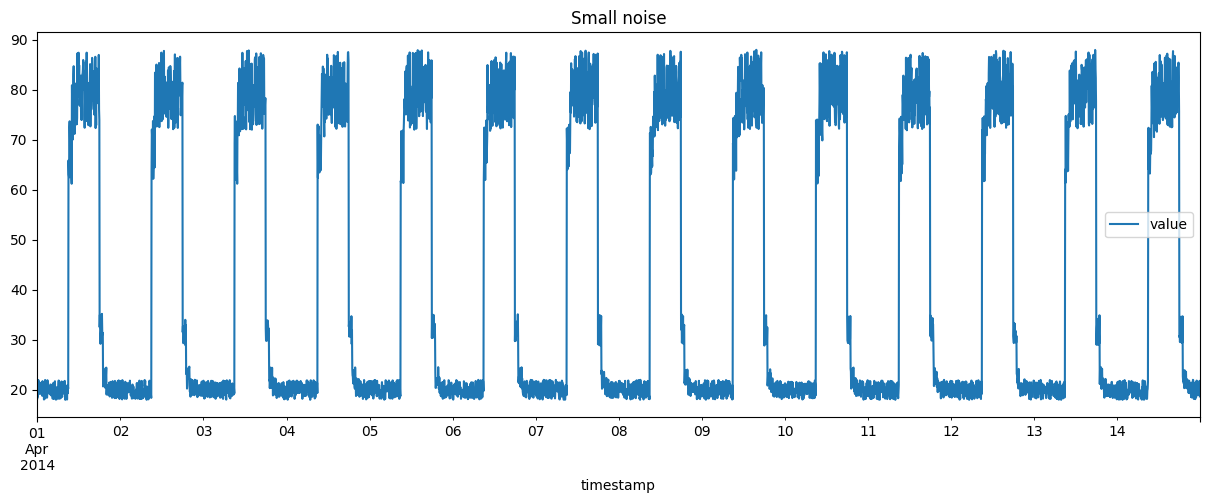

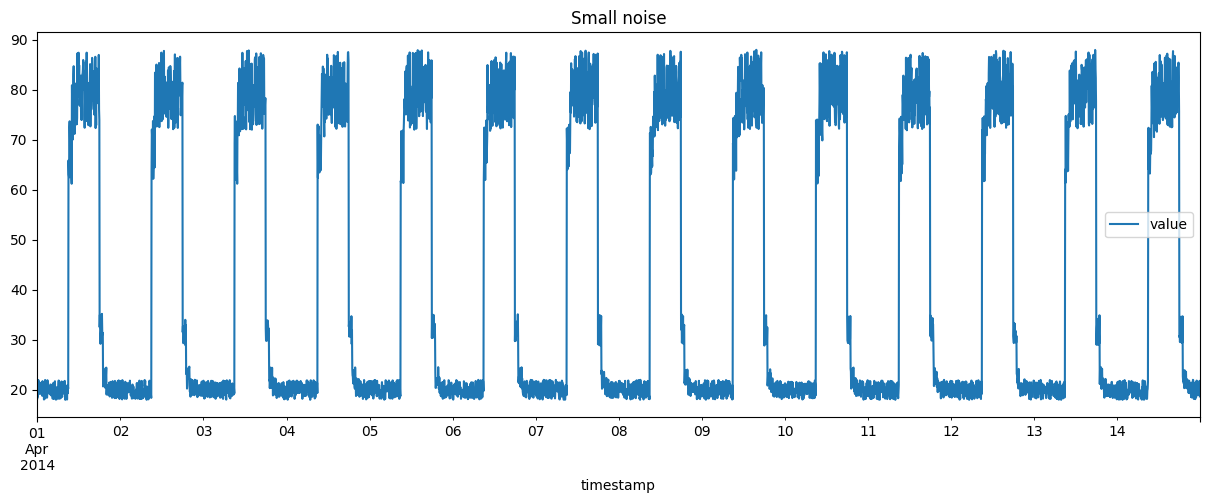

In [7]:
df_small_noise.plot(figsize=(15, 5), title="Small noise")
plt.show()

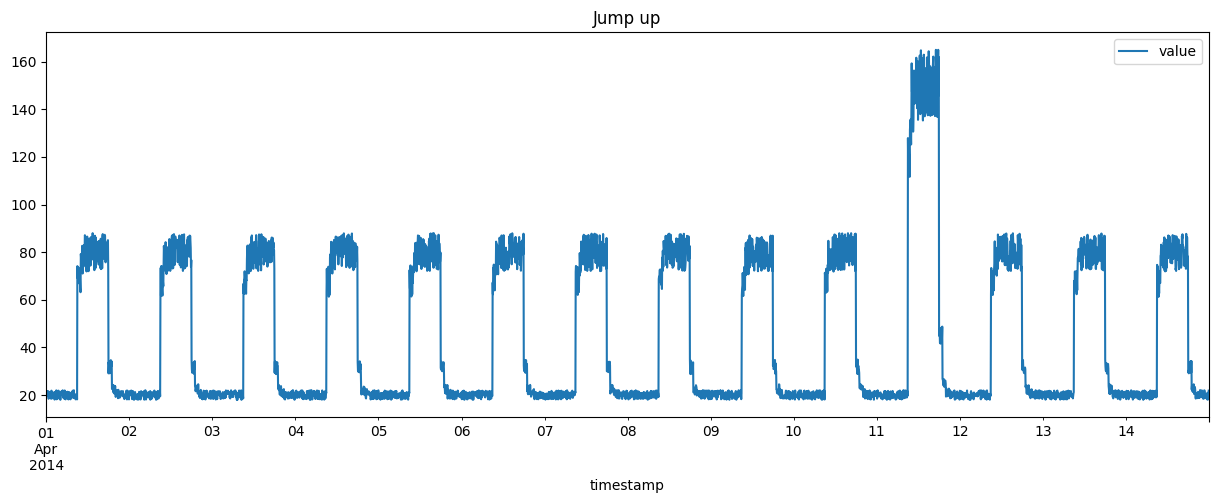

In [10]:
#time serries with anomalies
df_daily_jumpsup.plot(figsize=(15, 5), title="Jump up")
plt.show();

In [11]:
training_mean=df_small_noise.mean()
training_std=df_small_noise.std()
df_training_value=(df_small_noise-training_mean)/training_std
print(len(df_training_value))

4032


In [12]:
timesteps=288
def create_sequences(values,timesteps=timesteps):
    output=[]
    for i in range(len(values)-timesteps):
        output.append(values[i:(i+timesteps)])
    return np.stack(output)

In [15]:
x_train=create_sequences(df_training_value.values)

In [19]:
x_train.shape[0]

3744

In [20]:
model=keras.Sequential([


    layers.Input(shape=(x_train.shape[1],x_train.shape[2])),
    layers.Conv1D(filters=32,kernel_size=7,padding='same',strides=2,activation='relu'),
    layers.Conv1D(filters=16,kernel_size=7,padding='same',strides=2,activation='relu'),
    layers.Conv1DTranspose(filters=16,kernel_size=7,padding='same',strides=2,activation='relu'),
    layers.Conv1DTranspose(filters=32,kernel_size=7,padding='same',strides=2,activation='relu'),
    layers.Conv1DTranspose(filters=1,kernel_size=7,padding='same')

])

In [21]:
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 288, 1)           225       
 ranspose)                                                       
                                                        

In [23]:
history=model.fit(x_train,x_train,epochs=50,validation_split=0.02) #training x_train with x_train as this is a reconstruction model

Epoch 1/50
115/115 [==============================] - 2s 10ms/step - loss: 0.1400 - val_loss: 0.0213
Epoch 2/50
115/115 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0090
Epoch 3/50
115/115 [==============================] - 1s 8ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 4/50
115/115 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 5/50
115/115 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/50
115/115 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/50
115/115 [==============================] - 1s 7ms/step - loss: 9.6671e-04 - val_loss: 9.9624e-04
Epoch 8/50
115/115 [==============================] - 1s 8ms/step - loss: 8.4424e-04 - val_loss: 0.0010
Epoch 9/50
115/115 [==============================] - 1s 8ms/step - loss: 7.4940e-04 - val_loss: 7.6631e-04
Epoch 10/50
115/115 [==============================] - 1s 8ms/step - loss: 6.61

In [24]:
#find MAE loss on training samples
x_train_pred=model.predict(x_train)
train_mae_loss=np.mean(np.abs(x_train_pred-x_train),axis=1)

117/117 [==============================] - 1s 3ms/step


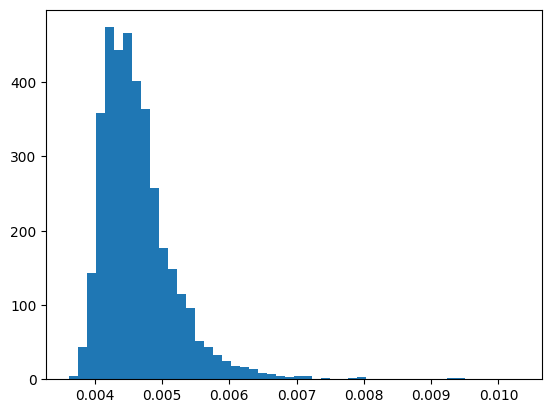

In [26]:
plt.hist(train_mae_loss,bins=50)
plt.show()

In [27]:
#threshold loss
threshold=np.max(train_mae_loss)

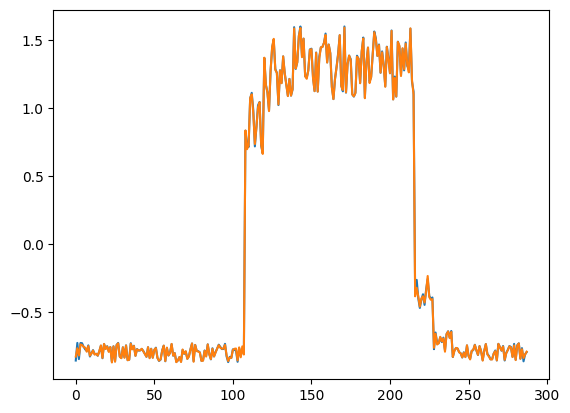

In [31]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

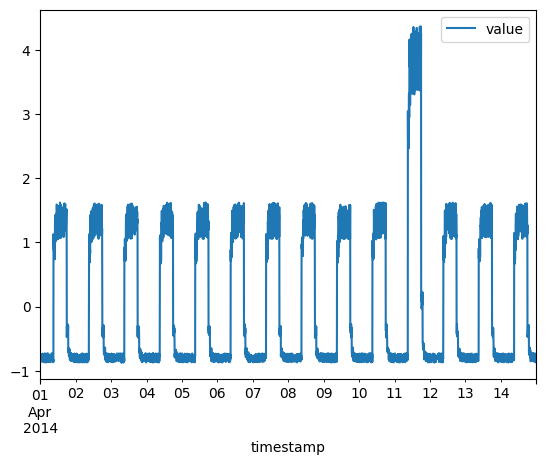

In [32]:
df_test_value=(df_daily_jumpsup-training_mean)/training_std
df_test_value.plot()
plt.show()

117/117 [==============================] - 0s 3ms/step


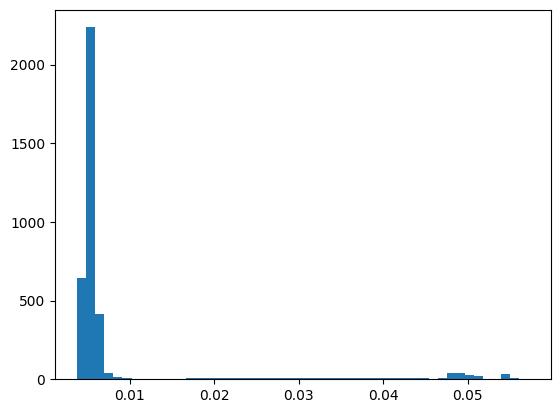

In [65]:
x_test=create_sequences(df_test_value.values)
x_test.shape
x_test_pred=model.predict(x_test)
test_mae_loss=np.mean(np.abs(x_test_pred-x_test),axis=1)
plt.hist(test_mae_loss,bins=50)
plt.show()

In [68]:
anomaly_df=pd.DataFrame(df_test_value[timesteps:])
anomaly_df['testMAE']=test_mae_loss
anomaly_df['max_train_mae']=np.max(train_mae_loss)
anomaly_df['anomaly']=anomaly_df['testMAE']>anomaly_df['max_train_mae']

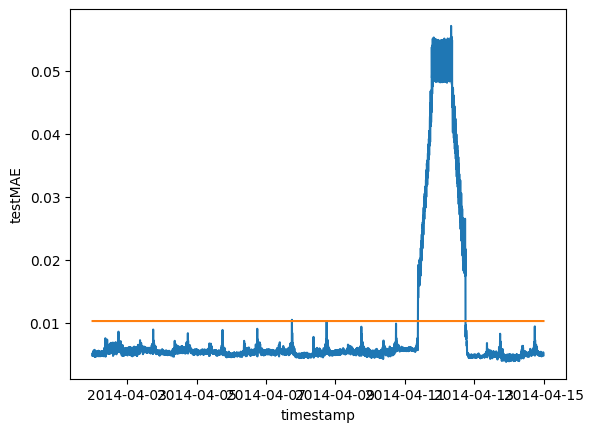

In [73]:
import seaborn as sns
sns.lineplot(data=anomaly_df,x=anomaly_df.index,y='testMAE')
sns.lineplot(data=anomaly_df,x=anomaly_df.index,y='max_train_mae')
plt.show()

In [76]:
anomalies=anomaly_df.loc[anomaly_df['anomaly']==True]
anomalies.head()

,value,testMAE,max_train_mae,anomaly
timestamp,,,,
2014-04-07 17:55:00,1.549294,0.010509,0.010313,True
2014-04-11 09:05:00,2.609504,0.013017,0.010313,True
2014-04-11 09:10:00,2.847445,0.017101,0.010313,True
2014-04-11 09:15:00,3.021065,0.013995,0.010313,True
2014-04-11 09:20:00,2.803693,0.017224,0.010313,True


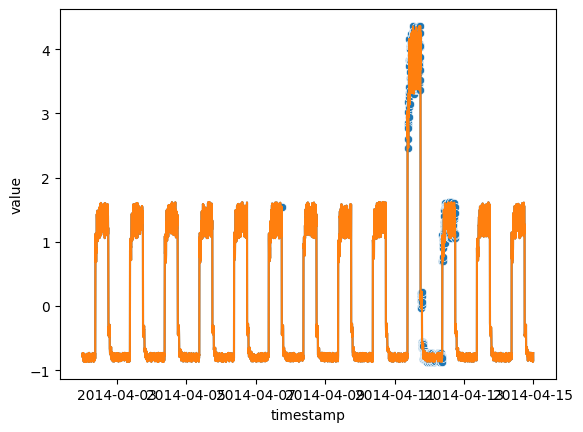

In [78]:
sns.lineplot(x=anomaly_df.index,y=anomaly_df['value'])
sns.scatterplot(x=anomalies.index,y=anomalies['value'])
plt.show()

In [74]:
anomaly_df.head()

,value,testMAE,max_train_mae,anomaly
timestamp,,,,
2014-04-02 00:00:00,-0.741876,0.004819,0.010313,False
2014-04-02 00:05:00,-0.793361,0.005233,0.010313,False
2014-04-02 00:10:00,-0.770681,0.004771,0.010313,False
2014-04-02 00:15:00,-0.752425,0.005298,0.010313,False
2014-04-02 00:20:00,-0.757634,0.004883,0.010313,False


In [60]:
anomalies=test_mae_loss>threshold
print("Indices of anomaly samples: ", np.where(anomalies))
len(df_test_value)

Indices of anomaly samples:  (array([1655, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
       2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842,
       2843, 2844, 28

4032

In [57]:
 anomaly_index=np.where(anomalies)
 plt.plot()

(array([1655, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
        2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
        2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
        2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
        2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
        2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
        2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
        2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
        2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
        2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
        2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
        2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
        2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842,
        2843, 2844, 2845, 2846, 2847, 

In [55]:
threshold

0.010313470511373553

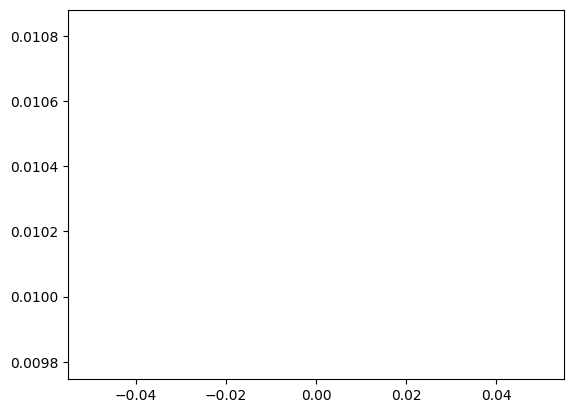

In [62]:
anomalies

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [64]:
a=[2,3,4,56]
a[0:2]

[2, 3]

In [40]:
#plot anomalies on test data
anomaly_data_index=[]
for data_idx in range(timesteps-1,len(df_test_value)-timesteps+1):
    if np.all(anomalies[data_idx-timesteps+1:data_idx]):
        anomaly_data_index.append(data_idx)
        

In [61]:
for data_idx in range(timesteps-1,len(df_test_value)-timesteps+1):
    print(data_idx)

287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536


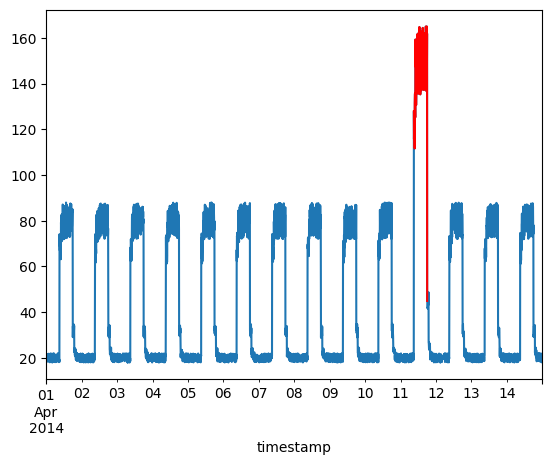

In [48]:
df_subset = df_daily_jumpsup.iloc[anomaly_data_index]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [ ]:
anomaly_data_index